In [2]:
%matplotlib inline
# useful additional packages 

#import math tools
import numpy as np
import dimod

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.optimization import QuadraticProgram

from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from scipy.optimize import minimize
from qiskit import BasicAer
from qiskit.optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer
from qiskit.optimization.applications.ising.common import random_graph, sample_most_likely
np.random.seed(42)

In [3]:
#### Generating Random QUBO matrix###
M = np.random.uniform(-2,2,(4,4))
QUBO = M + M.T
print(QUBO)

[[-1.00367905  0.42693179  1.33243581  1.7244045 ]
 [ 0.42693179 -2.75204384 -0.93537524  0.31406103]
 [ 1.33243581 -0.93537524 -3.83532405  0.60693928]
 [ 1.7244045   0.31406103  0.60693928 -2.53276392]]


In [4]:
#########  Extracting parameters for Quadratic Program   ##########

temp = np.copy(QUBO)
linear = np.diag(QUBO).tolist()
np.fill_diagonal(temp,0)
quadratic = temp.tolist()


# print(linear)
# print(quadratic)

In [5]:
######   Converting to Qiskit Quadratic Program    ###########


model = QuadraticProgram()
for i in range(QUBO.shape[0]):
    model.binary_var('x'+str(i))

model.minimize(linear=linear, quadratic=quadratic)
print(model.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 1.003679049221 x0 - 2.752043837310 x1 - 3.835324045634 x2
      - 2.532763921173 x3 + [ 1.707727149638 x0*x1 + 5.329743256874 x0*x2
      + 6.897617999959 x0*x3 - 3.741500960572 x1*x2 + 1.256244103251 x1*x3
      + 2.427757109906 x2*x3 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1

Binaries
 x0 x1 x2 x3
End



In [6]:
####### Getting Operators from Ising Hamiltonian   ########

operators , offset= model.to_ising()
print('offset: {}'.format(offset))
print('operator:')
print(operators)

offset: -3.3272068442868425
operator:
SummedOp([
  -1.2400465261982998 * IIIZ,
  1.4732131321155715 * IIZI,
  1.4156620970408826 * IZII,
  -0.0563204410532645 * ZIII,
  0.21346589370470537 * IIZZ,
  0.6662179071092278 * IZIZ,
  -0.4676876200715101 * IZZI,
  0.8622022499949167 * ZIIZ,
  0.15703051290642267 * ZIZI,
  0.3034696387381899 * ZZII
])


In [7]:
opt = COBYLA()
backend = BasicAer.get_backend('statevector_simulator')



qaoa = QAOA(operators, optimizer = opt, quantum_instance= backend, p = 1)
result = qaoa.compute_minimum_eigenvalue()

In [9]:
print('Most likely sample:',sample_most_likely(result.eigenstate))
print('Optimal cost:',offset + result.eigenvalue)
print('Optimal parameters:',result.optimal_parameters)

Most likely sample: [0. 1. 1. 1.]
Optimal cost: (-7.077592491145834+0j)
Optimal parameters: {Parameter(θ[0]): 0.4135190477086809, Parameter(θ[1]): 2.489995414817228}


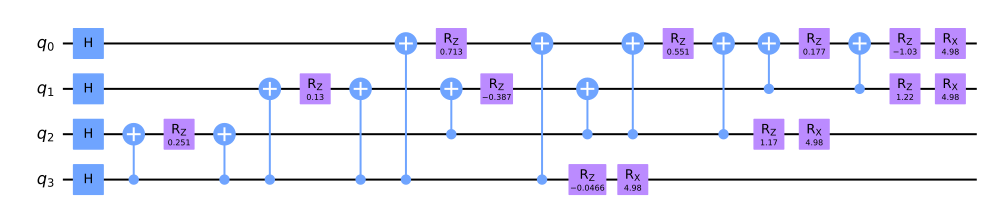

In [10]:
qaoa.get_optimal_circuit().draw('mpl')

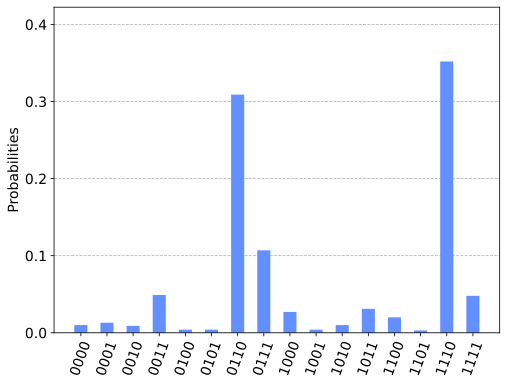

In [11]:
circuit = qaoa.get_optimal_circuit()
circuit.measure_all()

simulate = execute(circuit, backend=Aer.get_backend("qasm_simulator"), shots=1000)
QAOA_results = simulate.result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)